In [2]:
%cd "/content/drive/MyDrive/data/"
#!unzip "adult child.zip"

/content/drive/MyDrive/data


In [ ]:
!pip install timm
!pip install grad-cam

# 왜 이 기법을 사용했는지 이유
* 데이터 수가 적어 mixup, flip, crop 같은 데이터 증강 기법 사용(효과가 좋음)

* 깊은 모델 사용 -> 데이터셋이 적어 학습속도가 빠르기에 적은 메모리에도 충분히 가능 단점을 장점으로 만듦.

* SGD -> AdamW 정확도 상승에 큰 기여를함

* 데이터셋 내에 이미지에 이상치가 없는 걸로 보임. 이미지 길이도 똑같음.

* FC를 추가함으로써 모델 깊이와 연산량 증가.

* SiLU(efficientNet Activation Function이 SiLU이다.)

# 정리 포인트
* overfitting 방지를 위해 사용한 포인트들
- mixup 논문, augmentation, 깊은 모델 사용

* overfitting의 이유
데이터셋이 너무 작음 그래서 overfitting 방지가 쉬움.

* 깊은 모델을 사용하는 이유
일단 overfitting과 dataset이 작기 때문에 부담없이 사용가능하다. 그리고 FC를 추가해 더 깊게 만들었다.

* grad cam
정말 중요한 포인트다 내 모델이 어떤 포인트를 보고 분류했는지 꼭 알아야한다. 특히 찍어도 맞을 확률이 높기 때문에 grad cam으로 내 모델이 잘 분류한 것인지 꼭 확인해야한다. 




In [4]:
from torch import nn
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from tqdm.notebook import tqdm_notebook

import os
import torch
import cv2
import albumentations as A
import numpy as np
import timm
import torchvision.transforms as transforms
import torchvision

In [5]:
CFG={
    "BATCH":64,
    "LR":1e-4,
    "EPOCH":1000
}

In [6]:
#only train
labels=['children','adults']
image_files=[[os.path.join('./train',label,x) for x in os.listdir(os.path.join('./train',label))] for label in labels]

In [7]:
df_labels={
    'children':0,
    'adults':1
}
image_paths=[]
for i in range(2):
  for j in range(len(image_files[i])):
    current = image_files[i]
    image_paths.append(current[j])

In [8]:
print(f'children image : {len(image_files[0])} adults image : {len(image_files[1])}')

children image : 340 adults image : 340


이미지 수가 매우 적다. 그래서 oversample로 모델 수렴이든가 robust함을 높이자.

In [9]:
def aug_random_imshow(idx,name,transform):
  plt.figure(figsize=(10,10))

  image=cv2.imread(f"./train/{name}/{idx}.jpg")
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.subplot(1,2,1)
  plt.imshow(np.real(image))
  plt.title(f'{name} original')

  augmentations = transform(image=image)
  
  plt.subplot(1,2,2)
  plt.imshow(augmentations["image"])
  plt.title(f'{name} transform')

  plt.show()

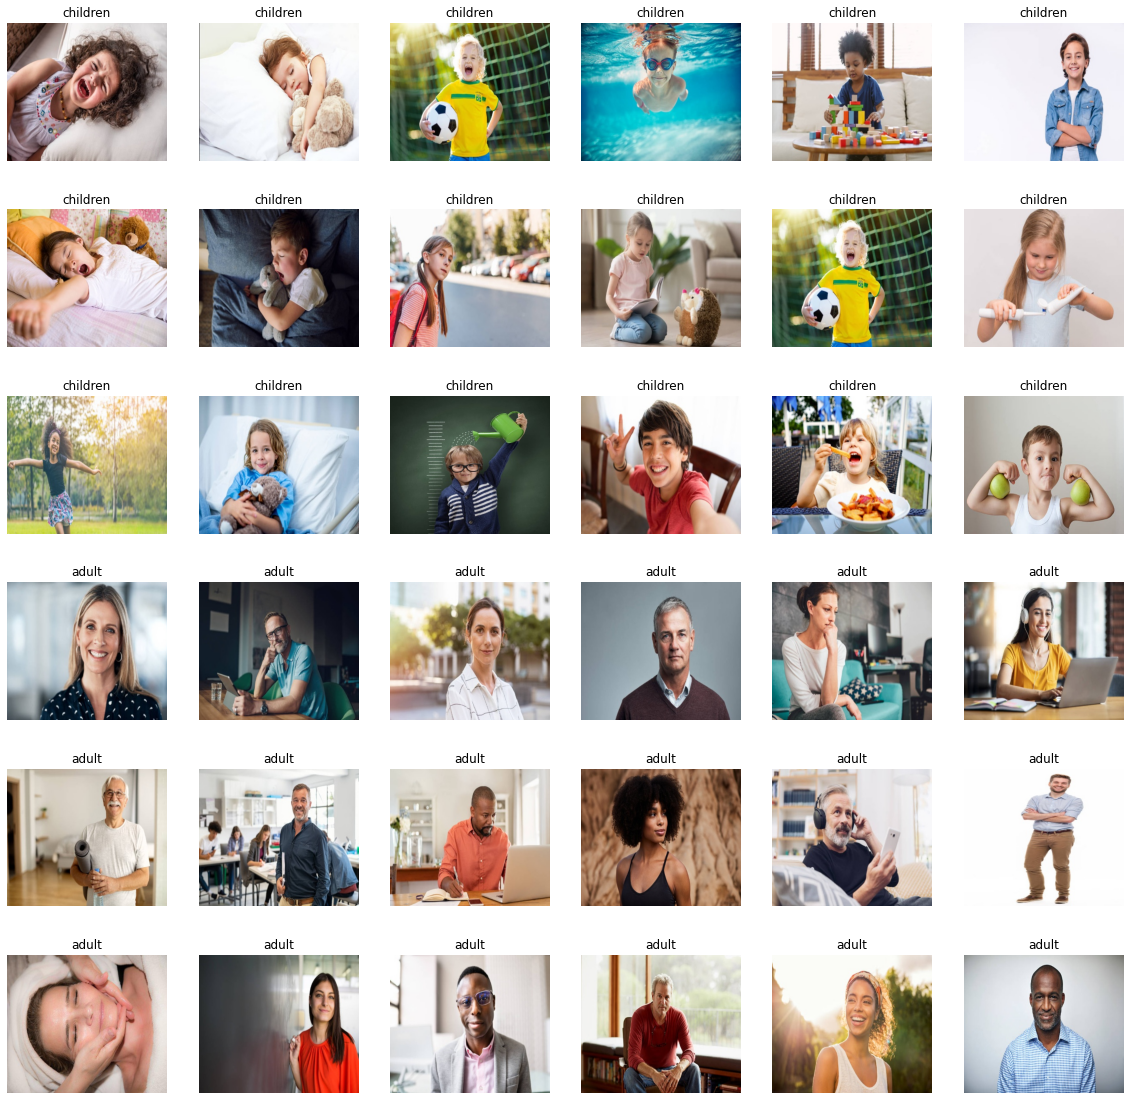

In [10]:
plt.figure(figsize=(20,20))
count=1
for n in range(2):
  for i in list(np.random.randint(0,len(image_files[n]),18)): 
      plt.subplot(6,6,count)
      image=cv2.imread(image_files[n][i])
      image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      plt.imshow(np.real(image))
      plt.axis('off')
      plt.title("children") if n==0 else plt.title("adult")
      count+=1

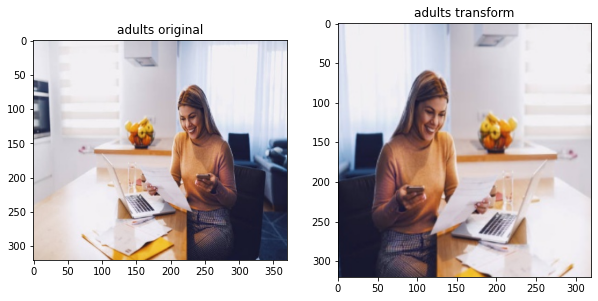

In [11]:
transform=A.Compose([
    A.HorizontalFlip(p=0.6),
    A.RandomSizedCrop(
        min_max_height=[210, 300],
        height=320, 
        width=320,
        p=0.6)
])

aug_random_imshow(96,'adults',transform)

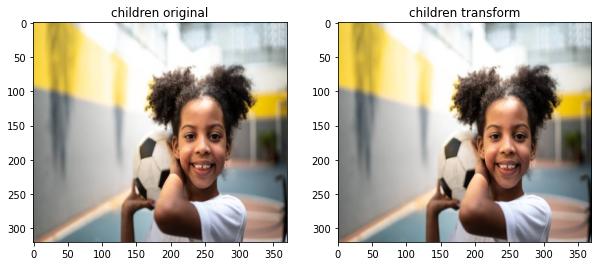

In [12]:
aug_random_imshow(96,'children',transform)

In [13]:
class CustomDataset(Dataset):
  def __init__(self,images_paths,targets,To_tensor,transforms=None):
    super(CustomDataset,self).__init__()
    self.image_paths=images_paths
    self.targets=targets
    self.To_tensor=To_tensor
    self.transforms=transforms
  
  def __len__(self):
    return len(self.image_paths)
  
  def __getitem__(self,idx):
    image_path=self.image_paths[idx]
    target=image_path.split('/')[-2]
    label=self.targets[target]

    image=cv2.imread(image_path)
    
    if self.transforms:
      image=self.transforms(image=image)
      image=Image.fromarray(image['image'].astype(np.uint8))
    else:
      image=Image.fromarray(image.astype(np.uint8))
    image=self.To_tensor(image)
    label=torch.tensor(label)

    return image.clone().detach(), label

In [14]:
train,valid=train_test_split(image_paths, test_size=0.2, shuffle=True, random_state=34)

In [15]:
To_tensor=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    ),
    transforms.Resize(
        size=(320,320)
    )
])

trian_transforms=A.Compose([
    A.HorizontalFlip(p=0.6),
    A.RandomSizedCrop(
        min_max_height=[210, 300],
        height=320, 
        width=320,
        p=0.6)
])



train_dataset=CustomDataset(train,df_labels,To_tensor,trian_transforms)
valid_dataset=CustomDataset(valid,df_labels,To_tensor)

train_dataloader=DataLoader(
    train_dataset,
    pin_memory=True,
    batch_size=CFG["BATCH"],
    num_workers=4,
    shuffle=True
    )

valid_dataloader=DataLoader(
    valid_dataset,
    pin_memory=True,
    batch_size=CFG["BATCH"],
    num_workers=4,
    shuffle=True
    )

In [16]:
class BaseModel(nn.Module):
  def __init__(self):
    super(BaseModel,self).__init__()
    self.model=timm.create_model('efficientnet_b3')
    self.SiLU=nn.SiLU(inplace=False)
    self.dropout=nn.Dropout(p=0.2)
    self.classifier = nn.Linear(1000, 2)  
    nn.init.xavier_normal_(self.classifier.weight)

  def forward(self,x):
    x = self.model(x)
    x = self.SiLU(x)
    x = self.dropout(x)
    x = self.classifier(x)
    return x

In [17]:
os.environ['WANDB_CONSOLE'] = 'off'

In [18]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
                            


In [19]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='./models/checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [20]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model=BaseModel().to(device)
optimizer=torch.optim.AdamW(model.parameters(),lr=CFG['LR'])
criterion=nn.CrossEntropyLoss().to(device)
scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=100,eta_min=0.001)

scaler = torch.cuda.amp.GradScaler()
early_stopping = EarlyStopping(patience = 100, verbose = True, path ='./models/checkpoint.pt')

In [ ]:
for epoch in range(1,CFG['EPOCH']+1):
  model_preds=[]
  true_labels=[]
  train_loss_list=[]

  valid_preds=[]
  valid_labels=[] 
  valid_loss_list=[]
  best_score=int(1e9)
  model.train()
  for data,label in tqdm_notebook(iter(train_dataloader)):
    data,label=data.to(device),label.to(device)

    data, targets_a, targets_b, lam = mixup_data(data, label)
    data, targets_a, targets_b = map(torch.autograd.Variable, (data, targets_a, targets_b))

    optimizer.zero_grad()
    with torch.cuda.amp.autocast():
      output=model(data)
    loss=mixup_criterion(criterion, output, targets_a, targets_b, lam)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    train_loss_list.append(loss.item())
    model_preds+=output.argmax(1).detach().cpu().numpy().tolist()
    true_labels+=label.detach().cpu().numpy().tolist()

  print(f'epoch {epoch} : "train loss : {np.mean(train_loss_list):.5f}", "train acc : {accuracy_score(true_labels, model_preds)}"')

  model.eval()
  with torch.no_grad():
    for data,label in tqdm_notebook(iter(valid_dataloader)):
      data,label=data.to(device),label.to(device)
      with torch.cuda.amp.autocast():
        output=model(data)
      valid_loss=criterion(output,label)
      valid_loss_list.append(valid_loss.item())
      valid_preds+=output.argmax(1).detach().cpu().numpy().tolist()
      valid_labels+=label.detach().cpu().numpy().tolist()
  print(f'epoch {epoch} : "valid loss : {np.mean(valid_loss_list):.5f}", "valid acc : {accuracy_score(valid_labels, valid_preds)}"')
  early_stopping(np.mean(valid_loss_list), model)
  if early_stopping.early_stop:
      print("Early stopping")
      break
  if scheduler is not None:
    scheduler.step() 

  0%|          | 0/9 [00:00<?, ?it/s]

epoch 1 : "train loss : 0.77463", "train acc : 0.49816176470588236"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 1 : "valid loss : 0.69580", "valid acc : 0.49264705882352944"
Validation loss decreased (inf --> 0.695801).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 2 : "train loss : 0.74219", "train acc : 0.5036764705882353"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 2 : "valid loss : 0.70020", "valid acc : 0.49264705882352944"
EarlyStopping counter: 1 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 3 : "train loss : 0.71479", "train acc : 0.5441176470588235"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 3 : "valid loss : 0.69385", "valid acc : 0.4852941176470588"
Validation loss decreased (0.695801 --> 0.693848).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 4 : "train loss : 0.69705", "train acc : 0.4963235294117647"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 4 : "valid loss : 0.67839", "valid acc : 0.5220588235294118"
Validation loss decreased (0.693848 --> 0.678385).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 5 : "train loss : 0.71376", "train acc : 0.47058823529411764"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 5 : "valid loss : 1.74007", "valid acc : 0.4411764705882353"
EarlyStopping counter: 1 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 6 : "train loss : 0.70085", "train acc : 0.5073529411764706"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 6 : "valid loss : 0.82178", "valid acc : 0.6838235294117647"
EarlyStopping counter: 2 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 7 : "train loss : 0.69960", "train acc : 0.4944852941176471"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 7 : "valid loss : 0.76318", "valid acc : 0.6029411764705882"
EarlyStopping counter: 3 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 8 : "train loss : 0.68511", "train acc : 0.49816176470588236"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 8 : "valid loss : 1.01644", "valid acc : 0.5955882352941176"
EarlyStopping counter: 4 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 9 : "train loss : 0.69922", "train acc : 0.5422794117647058"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 9 : "valid loss : 0.84749", "valid acc : 0.6102941176470589"
EarlyStopping counter: 5 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 10 : "train loss : 0.70285", "train acc : 0.5625"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 10 : "valid loss : 2.03548", "valid acc : 0.5073529411764706"
EarlyStopping counter: 6 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 11 : "train loss : 0.69179", "train acc : 0.5386029411764706"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 11 : "valid loss : 0.79557", "valid acc : 0.5441176470588235"
EarlyStopping counter: 7 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 12 : "train loss : 0.68772", "train acc : 0.5275735294117647"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 12 : "valid loss : 1.09717", "valid acc : 0.625"
EarlyStopping counter: 8 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 13 : "train loss : 0.68511", "train acc : 0.5533088235294118"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 13 : "valid loss : 0.89876", "valid acc : 0.6029411764705882"
EarlyStopping counter: 9 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 14 : "train loss : 0.69857", "train acc : 0.5257352941176471"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 14 : "valid loss : 2.06771", "valid acc : 0.5514705882352942"
EarlyStopping counter: 10 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 15 : "train loss : 0.66878", "train acc : 0.5808823529411765"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 15 : "valid loss : 1.55534", "valid acc : 0.6911764705882353"
EarlyStopping counter: 11 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 16 : "train loss : 0.67182", "train acc : 0.5661764705882353"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 16 : "valid loss : 4.07601", "valid acc : 0.4411764705882353"
EarlyStopping counter: 12 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 17 : "train loss : 0.66298", "train acc : 0.5680147058823529"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 17 : "valid loss : 2.97135", "valid acc : 0.6176470588235294"
EarlyStopping counter: 13 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 18 : "train loss : 0.66368", "train acc : 0.5974264705882353"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 18 : "valid loss : 0.74007", "valid acc : 0.6102941176470589"
EarlyStopping counter: 14 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 19 : "train loss : 0.67057", "train acc : 0.5220588235294118"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 19 : "valid loss : 1.16146", "valid acc : 0.5955882352941176"
EarlyStopping counter: 15 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 20 : "train loss : 0.67084", "train acc : 0.5275735294117647"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 20 : "valid loss : 1.09749", "valid acc : 0.6470588235294118"
EarlyStopping counter: 16 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 21 : "train loss : 0.65592", "train acc : 0.5404411764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 21 : "valid loss : 0.70060", "valid acc : 0.6617647058823529"
EarlyStopping counter: 17 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 22 : "train loss : 0.64431", "train acc : 0.5716911764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 22 : "valid loss : 0.63851", "valid acc : 0.6617647058823529"
Validation loss decreased (0.678385 --> 0.638509).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 23 : "train loss : 0.64274", "train acc : 0.5955882352941176"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 23 : "valid loss : 0.86084", "valid acc : 0.6323529411764706"
EarlyStopping counter: 1 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 24 : "train loss : 0.64730", "train acc : 0.5808823529411765"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 24 : "valid loss : 0.79590", "valid acc : 0.6691176470588235"
EarlyStopping counter: 2 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 25 : "train loss : 0.68679", "train acc : 0.5551470588235294"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 25 : "valid loss : 0.70654", "valid acc : 0.6617647058823529"
EarlyStopping counter: 3 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 26 : "train loss : 0.64703", "train acc : 0.6213235294117647"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 26 : "valid loss : 0.64274", "valid acc : 0.6470588235294118"
EarlyStopping counter: 4 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 27 : "train loss : 0.64214", "train acc : 0.5459558823529411"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 27 : "valid loss : 0.60352", "valid acc : 0.6029411764705882"
Validation loss decreased (0.638509 --> 0.603516).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 28 : "train loss : 0.62164", "train acc : 0.5808823529411765"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 28 : "valid loss : 0.65658", "valid acc : 0.625"
EarlyStopping counter: 1 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 29 : "train loss : 0.63075", "train acc : 0.5919117647058824"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 29 : "valid loss : 0.92578", "valid acc : 0.6470588235294118"
EarlyStopping counter: 2 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 30 : "train loss : 0.65940", "train acc : 0.5257352941176471"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 30 : "valid loss : 3.03613", "valid acc : 0.5955882352941176"
EarlyStopping counter: 3 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 31 : "train loss : 0.61361", "train acc : 0.6029411764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 31 : "valid loss : 0.82699", "valid acc : 0.7058823529411765"
EarlyStopping counter: 4 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 32 : "train loss : 0.66678", "train acc : 0.5661764705882353"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 32 : "valid loss : 0.63411", "valid acc : 0.7132352941176471"
EarlyStopping counter: 5 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 33 : "train loss : 0.62207", "train acc : 0.6470588235294118"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 33 : "valid loss : 0.71549", "valid acc : 0.6985294117647058"
EarlyStopping counter: 6 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 34 : "train loss : 0.65044", "train acc : 0.5863970588235294"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 34 : "valid loss : 0.79102", "valid acc : 0.7132352941176471"
EarlyStopping counter: 7 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 35 : "train loss : 0.63281", "train acc : 0.6360294117647058"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 35 : "valid loss : 0.68750", "valid acc : 0.6911764705882353"
EarlyStopping counter: 8 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 36 : "train loss : 0.65115", "train acc : 0.6029411764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 36 : "valid loss : 0.64811", "valid acc : 0.6911764705882353"
EarlyStopping counter: 9 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 37 : "train loss : 0.63997", "train acc : 0.6158088235294118"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 37 : "valid loss : 0.57471", "valid acc : 0.6985294117647058"
Validation loss decreased (0.603516 --> 0.574707).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 38 : "train loss : 0.60010", "train acc : 0.6231617647058824"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 38 : "valid loss : 0.59912", "valid acc : 0.6911764705882353"
EarlyStopping counter: 1 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 39 : "train loss : 0.63808", "train acc : 0.6084558823529411"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 39 : "valid loss : 0.69466", "valid acc : 0.6544117647058824"
EarlyStopping counter: 2 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 40 : "train loss : 0.60449", "train acc : 0.6654411764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 40 : "valid loss : 0.71305", "valid acc : 0.625"
EarlyStopping counter: 3 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 41 : "train loss : 0.66195", "train acc : 0.5551470588235294"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 41 : "valid loss : 1.23438", "valid acc : 0.6470588235294118"
EarlyStopping counter: 4 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 42 : "train loss : 0.63786", "train acc : 0.6139705882352942"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 42 : "valid loss : 0.62842", "valid acc : 0.7058823529411765"
EarlyStopping counter: 5 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 43 : "train loss : 0.63748", "train acc : 0.6415441176470589"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 43 : "valid loss : 0.65934", "valid acc : 0.7279411764705882"
EarlyStopping counter: 6 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 44 : "train loss : 0.60173", "train acc : 0.6415441176470589"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 44 : "valid loss : 1.01872", "valid acc : 0.6102941176470589"
EarlyStopping counter: 7 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 45 : "train loss : 0.65967", "train acc : 0.6139705882352942"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 45 : "valid loss : 0.57682", "valid acc : 0.6691176470588235"
EarlyStopping counter: 8 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 46 : "train loss : 0.62210", "train acc : 0.5992647058823529"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 46 : "valid loss : 0.54867", "valid acc : 0.6911764705882353"
Validation loss decreased (0.574707 --> 0.548665).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 47 : "train loss : 0.60525", "train acc : 0.5753676470588235"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 47 : "valid loss : 0.58081", "valid acc : 0.6838235294117647"
EarlyStopping counter: 1 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 48 : "train loss : 0.62240", "train acc : 0.6415441176470589"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 48 : "valid loss : 0.55729", "valid acc : 0.7132352941176471"
EarlyStopping counter: 2 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 49 : "train loss : 0.61811", "train acc : 0.6856617647058824"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 49 : "valid loss : 0.62581", "valid acc : 0.7205882352941176"
EarlyStopping counter: 3 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 50 : "train loss : 0.63097", "train acc : 0.5588235294117647"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 50 : "valid loss : 0.63883", "valid acc : 0.6691176470588235"
EarlyStopping counter: 4 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 51 : "train loss : 0.60514", "train acc : 0.65625"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 51 : "valid loss : 0.69173", "valid acc : 0.6323529411764706"
EarlyStopping counter: 5 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 52 : "train loss : 0.60365", "train acc : 0.5514705882352942"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 52 : "valid loss : 0.60335", "valid acc : 0.6838235294117647"
EarlyStopping counter: 6 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 53 : "train loss : 0.59500", "train acc : 0.6727941176470589"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 53 : "valid loss : 1.06315", "valid acc : 0.6691176470588235"
EarlyStopping counter: 7 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 54 : "train loss : 0.56776", "train acc : 0.6819852941176471"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 54 : "valid loss : 0.75488", "valid acc : 0.6764705882352942"
EarlyStopping counter: 8 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 55 : "train loss : 0.56066", "train acc : 0.6525735294117647"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 55 : "valid loss : 0.69759", "valid acc : 0.6838235294117647"
EarlyStopping counter: 9 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 56 : "train loss : 0.58746", "train acc : 0.6029411764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 56 : "valid loss : 0.66943", "valid acc : 0.6838235294117647"
EarlyStopping counter: 10 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 57 : "train loss : 0.55531", "train acc : 0.6488970588235294"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 57 : "valid loss : 0.64461", "valid acc : 0.6102941176470589"
EarlyStopping counter: 11 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 58 : "train loss : 0.59543", "train acc : 0.6121323529411765"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 58 : "valid loss : 0.78337", "valid acc : 0.6764705882352942"
EarlyStopping counter: 12 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 59 : "train loss : 0.61551", "train acc : 0.6746323529411765"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 59 : "valid loss : 0.62858", "valid acc : 0.6397058823529411"
EarlyStopping counter: 13 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 60 : "train loss : 0.58176", "train acc : 0.7334558823529411"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 60 : "valid loss : 0.94222", "valid acc : 0.5882352941176471"
EarlyStopping counter: 14 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 61 : "train loss : 0.58653", "train acc : 0.65625"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 61 : "valid loss : 0.69352", "valid acc : 0.7132352941176471"
EarlyStopping counter: 15 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 62 : "train loss : 0.58328", "train acc : 0.6746323529411765"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 62 : "valid loss : 0.83333", "valid acc : 0.6544117647058824"
EarlyStopping counter: 16 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 63 : "train loss : 0.58629", "train acc : 0.6158088235294118"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 63 : "valid loss : 0.63265", "valid acc : 0.6323529411764706"
EarlyStopping counter: 17 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 64 : "train loss : 0.51459", "train acc : 0.7334558823529411"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 64 : "valid loss : 0.91650", "valid acc : 0.6102941176470589"
EarlyStopping counter: 18 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 65 : "train loss : 0.58865", "train acc : 0.6470588235294118"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 65 : "valid loss : 0.68555", "valid acc : 0.6029411764705882"
EarlyStopping counter: 19 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 66 : "train loss : 0.59988", "train acc : 0.5882352941176471"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 66 : "valid loss : 0.92253", "valid acc : 0.6029411764705882"
EarlyStopping counter: 20 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 67 : "train loss : 0.54148", "train acc : 0.7003676470588235"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 67 : "valid loss : 0.66585", "valid acc : 0.6544117647058824"
EarlyStopping counter: 21 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 68 : "train loss : 0.53762", "train acc : 0.5845588235294118"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 68 : "valid loss : 0.74805", "valid acc : 0.6397058823529411"
EarlyStopping counter: 22 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 69 : "train loss : 0.53044", "train acc : 0.6544117647058824"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 69 : "valid loss : 0.64079", "valid acc : 0.6985294117647058"
EarlyStopping counter: 23 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 70 : "train loss : 0.61640", "train acc : 0.5349264705882353"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 70 : "valid loss : 0.70638", "valid acc : 0.6397058823529411"
EarlyStopping counter: 24 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 71 : "train loss : 0.56095", "train acc : 0.6305147058823529"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 71 : "valid loss : 0.63900", "valid acc : 0.6764705882352942"
EarlyStopping counter: 25 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 72 : "train loss : 0.60164", "train acc : 0.6966911764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 72 : "valid loss : 0.55623", "valid acc : 0.6911764705882353"
EarlyStopping counter: 26 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 73 : "train loss : 0.53239", "train acc : 0.6084558823529411"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 73 : "valid loss : 0.93766", "valid acc : 0.5955882352941176"
EarlyStopping counter: 27 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 74 : "train loss : 0.50513", "train acc : 0.6856617647058824"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 74 : "valid loss : 0.64925", "valid acc : 0.6470588235294118"
EarlyStopping counter: 28 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 75 : "train loss : 0.56093", "train acc : 0.7022058823529411"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 75 : "valid loss : 0.57772", "valid acc : 0.6617647058823529"
EarlyStopping counter: 29 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 76 : "train loss : 0.58236", "train acc : 0.625"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 76 : "valid loss : 0.56380", "valid acc : 0.6985294117647058"
EarlyStopping counter: 30 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 77 : "train loss : 0.53318", "train acc : 0.7261029411764706"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 77 : "valid loss : 0.67839", "valid acc : 0.7058823529411765"
EarlyStopping counter: 31 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 78 : "train loss : 0.53920", "train acc : 0.5808823529411765"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 78 : "valid loss : 0.80046", "valid acc : 0.5882352941176471"
EarlyStopping counter: 32 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 79 : "train loss : 0.52846", "train acc : 0.6470588235294118"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 79 : "valid loss : 0.64046", "valid acc : 0.6544117647058824"
EarlyStopping counter: 33 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 80 : "train loss : 0.53396", "train acc : 0.7095588235294118"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 80 : "valid loss : 0.65511", "valid acc : 0.6323529411764706"
EarlyStopping counter: 34 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 81 : "train loss : 0.56871", "train acc : 0.6029411764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 81 : "valid loss : 0.69727", "valid acc : 0.6764705882352942"
EarlyStopping counter: 35 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 82 : "train loss : 0.47930", "train acc : 0.625"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 82 : "valid loss : 0.64111", "valid acc : 0.7058823529411765"
EarlyStopping counter: 36 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 83 : "train loss : 0.51375", "train acc : 0.6966911764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 83 : "valid loss : 0.54541", "valid acc : 0.6985294117647058"
Validation loss decreased (0.548665 --> 0.545410).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 84 : "train loss : 0.49992", "train acc : 0.7922794117647058"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 84 : "valid loss : 0.66992", "valid acc : 0.6838235294117647"
EarlyStopping counter: 1 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 85 : "train loss : 0.50898", "train acc : 0.7169117647058824"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 85 : "valid loss : 0.64176", "valid acc : 0.6911764705882353"
EarlyStopping counter: 2 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 86 : "train loss : 0.50464", "train acc : 0.7150735294117647"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 86 : "valid loss : 0.53206", "valid acc : 0.6397058823529411"
Validation loss decreased (0.545410 --> 0.532064).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 87 : "train loss : 0.52501", "train acc : 0.6378676470588235"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 87 : "valid loss : 0.67741", "valid acc : 0.6617647058823529"
EarlyStopping counter: 1 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 88 : "train loss : 0.53263", "train acc : 0.5790441176470589"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 88 : "valid loss : 0.74707", "valid acc : 0.7205882352941176"
EarlyStopping counter: 2 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 89 : "train loss : 0.53092", "train acc : 0.6286764705882353"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 89 : "valid loss : 0.59505", "valid acc : 0.7058823529411765"
EarlyStopping counter: 3 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 90 : "train loss : 0.46229", "train acc : 0.7022058823529411"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 90 : "valid loss : 0.56836", "valid acc : 0.75"
EarlyStopping counter: 4 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 91 : "train loss : 0.51761", "train acc : 0.7591911764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 91 : "valid loss : 0.53988", "valid acc : 0.6911764705882353"
EarlyStopping counter: 5 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 92 : "train loss : 0.53860", "train acc : 0.6783088235294118"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 92 : "valid loss : 0.52702", "valid acc : 0.6985294117647058"
Validation loss decreased (0.532064 --> 0.527018).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 93 : "train loss : 0.47868", "train acc : 0.7022058823529411"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 93 : "valid loss : 0.71436", "valid acc : 0.6617647058823529"
EarlyStopping counter: 1 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 94 : "train loss : 0.47534", "train acc : 0.6231617647058824"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 94 : "valid loss : 0.66715", "valid acc : 0.6911764705882353"
EarlyStopping counter: 2 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 95 : "train loss : 0.44027", "train acc : 0.8088235294117647"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 95 : "valid loss : 0.72119", "valid acc : 0.6911764705882353"
EarlyStopping counter: 3 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 96 : "train loss : 0.51527", "train acc : 0.7279411764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 96 : "valid loss : 0.65853", "valid acc : 0.625"
EarlyStopping counter: 4 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 97 : "train loss : 0.50342", "train acc : 0.7150735294117647"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 97 : "valid loss : 0.64014", "valid acc : 0.7279411764705882"
EarlyStopping counter: 5 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 98 : "train loss : 0.52355", "train acc : 0.5753676470588235"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 98 : "valid loss : 0.66699", "valid acc : 0.6691176470588235"
EarlyStopping counter: 6 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 99 : "train loss : 0.45988", "train acc : 0.6323529411764706"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 99 : "valid loss : 0.76676", "valid acc : 0.6617647058823529"
EarlyStopping counter: 7 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 100 : "train loss : 0.54088", "train acc : 0.6654411764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 100 : "valid loss : 0.58301", "valid acc : 0.7279411764705882"
EarlyStopping counter: 8 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 101 : "train loss : 0.48790", "train acc : 0.7058823529411765"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 101 : "valid loss : 0.62972", "valid acc : 0.7132352941176471"
EarlyStopping counter: 9 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 102 : "train loss : 0.49620", "train acc : 0.6875"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 102 : "valid loss : 0.56722", "valid acc : 0.6544117647058824"
EarlyStopping counter: 10 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 103 : "train loss : 0.51997", "train acc : 0.8216911764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 103 : "valid loss : 0.56510", "valid acc : 0.6691176470588235"
EarlyStopping counter: 11 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 104 : "train loss : 0.49067", "train acc : 0.6470588235294118"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 104 : "valid loss : 0.47681", "valid acc : 0.6985294117647058"
Validation loss decreased (0.527018 --> 0.476807).  Saving model ...


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 105 : "train loss : 0.41616", "train acc : 0.75"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 105 : "valid loss : 0.56689", "valid acc : 0.7720588235294118"
EarlyStopping counter: 1 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 106 : "train loss : 0.47396", "train acc : 0.6856617647058824"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 106 : "valid loss : 0.53239", "valid acc : 0.7426470588235294"
EarlyStopping counter: 2 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 107 : "train loss : 0.47382", "train acc : 0.7610294117647058"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 107 : "valid loss : 0.71549", "valid acc : 0.5955882352941176"
EarlyStopping counter: 3 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 108 : "train loss : 0.45947", "train acc : 0.6452205882352942"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 108 : "valid loss : 0.72249", "valid acc : 0.6911764705882353"
EarlyStopping counter: 4 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 109 : "train loss : 0.50350", "train acc : 0.6746323529411765"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 109 : "valid loss : 0.62516", "valid acc : 0.6911764705882353"
EarlyStopping counter: 5 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 110 : "train loss : 0.49463", "train acc : 0.7591911764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 110 : "valid loss : 0.58211", "valid acc : 0.6470588235294118"
EarlyStopping counter: 6 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 111 : "train loss : 0.43286", "train acc : 0.7794117647058824"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 111 : "valid loss : 0.55176", "valid acc : 0.7279411764705882"
EarlyStopping counter: 7 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 112 : "train loss : 0.45323", "train acc : 0.6672794117647058"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 112 : "valid loss : 0.63330", "valid acc : 0.6985294117647058"
EarlyStopping counter: 8 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 113 : "train loss : 0.44851", "train acc : 0.7444852941176471"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 113 : "valid loss : 0.56291", "valid acc : 0.7058823529411765"
EarlyStopping counter: 9 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 114 : "train loss : 0.51400", "train acc : 0.7628676470588235"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 114 : "valid loss : 0.60921", "valid acc : 0.6838235294117647"
EarlyStopping counter: 10 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 115 : "train loss : 0.46601", "train acc : 0.6268382352941176"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 115 : "valid loss : 0.72965", "valid acc : 0.7352941176470589"
EarlyStopping counter: 11 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 116 : "train loss : 0.42395", "train acc : 0.7444852941176471"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 116 : "valid loss : 0.64893", "valid acc : 0.7352941176470589"
EarlyStopping counter: 12 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 117 : "train loss : 0.49555", "train acc : 0.7242647058823529"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 117 : "valid loss : 0.65251", "valid acc : 0.7205882352941176"
EarlyStopping counter: 13 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 118 : "train loss : 0.48242", "train acc : 0.6488970588235294"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 118 : "valid loss : 0.68962", "valid acc : 0.7058823529411765"
EarlyStopping counter: 14 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 119 : "train loss : 0.50328", "train acc : 0.7132352941176471"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 119 : "valid loss : 0.63607", "valid acc : 0.6691176470588235"
EarlyStopping counter: 15 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 120 : "train loss : 0.44415", "train acc : 0.7591911764705882"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 120 : "valid loss : 0.52547", "valid acc : 0.6911764705882353"
EarlyStopping counter: 16 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 121 : "train loss : 0.47008", "train acc : 0.6875"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 121 : "valid loss : 0.61328", "valid acc : 0.6985294117647058"
EarlyStopping counter: 17 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 122 : "train loss : 0.48802", "train acc : 0.7334558823529411"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 122 : "valid loss : 0.76571", "valid acc : 0.75"
EarlyStopping counter: 18 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 123 : "train loss : 0.46170", "train acc : 0.7628676470588235"


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 123 : "valid loss : 0.53410", "valid acc : 0.6911764705882353"
EarlyStopping counter: 19 out of 100


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 124 : "train loss : 0.47228", "train acc : 0.7371323529411765"


  0%|          | 0/3 [00:00<?, ?it/s]

# Inference

In [ ]:
image_files=[[os.path.join('./test',label,x) for x in os.listdir(os.path.join('./test',label))] for label in labels]

test=[]
for i in range(2):
  for j in range(len(image_files[i])):
    current = image_files[i]
    test.append(current[j])

In [ ]:
test_dataset=CustomDataset(test,df_labels,To_tensor)
model.load_state_dict(torch.load("./models/checkpoint.pt",map_location=device))# 내가 학습시킨 모델 weight를 모델에 입혀줍니다.

test_dataloader=DataLoader(
    test_dataset,
    pin_memory=True,
    batch_size=CFG["BATCH"],
    num_workers=4,
)

In [ ]:
model.eval()
test_loss=[]
test_labels=[]
test_preds=[]
with torch.no_grad():
  for data,label in tqdm_notebook(iter(test_dataloader)):
    data,label=data.to(device),label.to(device)
    output=model(data)
    loss=criterion(output,label)
    test_loss.append(loss.item())
    test_preds+=output.argmax(1).detach().cpu().numpy().tolist()
    test_labels+=label.detach().cpu().numpy().tolist()
  print(f'"test loss : {np.mean(test_loss):.5f}", "test acc : {accuracy_score(test_labels, test_preds)}"')

# grad cam

In [ ]:
target_layers = [model.model.conv_head]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
model.load_state_dict(torch.load("./models/checkpoint.pt",map_location=device))# 내가 학습시킨 모델 weight를 모델에 입혀줍니다.

In [ ]:
def grad_cam_image(idx,name):
  path=f"./train/{name}/{idx}.jpg"
  img=cv2.imread(path)
  img = Image.fromarray(img)
  img = torchvision.transforms.Resize((320, 320))(img)
  img = torchvision.transforms.ToTensor()(img)
  img = torchvision.transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))(img)
  img = img.unsqueeze(0)
  img=img.to(device)

  pred = int(torch.argmax(torch.nn.Softmax()(model(img))).item())
  targets = [ClassifierOutputTarget(pred)]

  image=cv2.imread(path,cv2.IMREAD_COLOR)
  image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  image=cv2.resize(image, dsize=(320, 320))

  grayscale_cam = cam(input_tensor=img, targets=targets)
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
  plt.imshow(visualization)


In [ ]:
grad_cam_image(72 ,'adults')

In [ ]:
grad_cam_image(72,'children')